<a href="https://colab.research.google.com/github/atharvadesai1/BE-Project-Codes/blob/main/alziehmer_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
# !unzip -q /content/datasets/MildDemented.zip -d /content/datasets/MildDemented
# !unzip -q /content/datasets/ModerateDemented.zip -d /content/datasets/ModerateDemented
# !unzip -q /content/datasets/NonDemented.zip -d /content/datasets/NonDemented
# !unzip -q /content/datasets/VeryMildDemented.zip -d /content/datasets/VeryMildDemented

In [ ]:
# Step 1: Define Constants
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
BATCH_SIZE = 32

In [ ]:
# !rm -rf "/content/datasets/.ipynb_checkpoints"

In [ ]:
# Step 2: Prepare Data
data_dir = "/content/datasets"

In [ ]:
# Data Augmentation
image_generator = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.99, 1.01],
    data_format="channels_last",
    fill_mode="constant",
    horizontal_flip=True,
    validation_split=0.2  # changes done here: Added validation split
)

In [ ]:
train_dataset = image_generator.flow_from_directory(
    directory=data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="training",  # changes done here: Specify subset for training
    class_mode="categorical"
)

Found 35200 images belonging to 4 classes.


In [ ]:
val_dataset = image_generator.flow_from_directory(
    directory=data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset="validation",  # changes done here: Specify subset for validation
    class_mode="categorical"
)

Found 8800 images belonging to 4 classes.


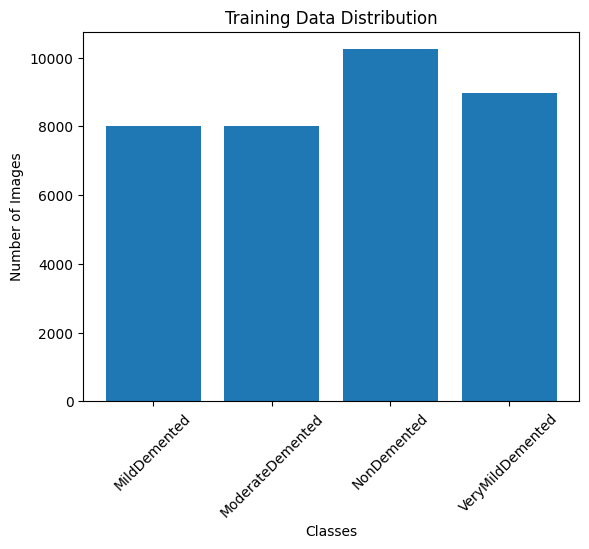

In [ ]:
# Step 3: Visualize Data Distribution
import matplotlib.pyplot as plt
from collections import Counter

# Map class indices to class names using the `class_indices` attribute
index_to_class = {v: k for k, v in train_dataset.class_indices.items()}  # Reverse the dictionary

# Count the occurrences of each class index
class_counts = Counter(train_dataset.classes)

# Map class indices to class names for visualization
class_names = [index_to_class[i] for i in class_counts.keys()]

# Create the bar chart
plt.bar(class_names, class_counts.values())
plt.title("Training Data Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)  # Rotate class names for better readability if needed
plt.show()


In [ ]:
# Step 2: Data Augmentation
image_generator = ImageDataGenerator(
    brightness_range=[0.8, 1.2],
    zoom_range=[0.99, 1.01],
    horizontal_flip=True,
    fill_mode="constant"
)

In [ ]:
# Step 4: Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')  # Output layer for classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import os
print(os.listdir("/content/datasets"))


['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']


In [ ]:
# Step 5: Train the Model
print("Training the model...")

# Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  # changes done here: Added EarlyStopping

history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # changes done here: Added validation dataset
    epochs=20,
    callbacks=[early_stopping]
)

Training the model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2617s 2s/step - accuracy: 0.5049 - loss: 1.1187 - val_accuracy: 0.7098 - val_loss: 0.6433
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2631s 2s/step - accuracy: 0.7143 - loss: 0.6464 - val_accuracy: 0.7716 - val_loss: 0.5294
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2586s 2s/step - accuracy: 0.7693 - loss: 0.5272 - val_accuracy: 0.8138 - val_loss: 0.4422
Epoch 4/20
 553/1100 ━━━━━━━━━━━━━━━━━━━━ 19:10 2s/step - accuracy: 0.8097 - loss: 0.4408

In [ ]:
# Step 6: Save the Model in `.h5` Format
model.save("my_model.h5")  # changes done here: Save the model in .h5 format
print("Model saved as my_model.h5")

In [ ]:
# Step 7: Visualize Training Results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # changes done here: Include validation metrics
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # changes done here: Include validation loss
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

In [ ]:
# Step 8: Test the Model on an Unseen Image
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = CLASSES[np.argmax(predictions)]
    confidence = np.max(predictions)

    print(f"Predicted Class: {predicted_class} with confidence {confidence:.2f}")
    return predicted_class, confidence